In [415]:
include("../../src/WaterLily.jl")
WaterLily = Main.WaterLily;
using Plots; gr()
using StaticArrays
using JLD
using Statistics

In [416]:
inside(a::AbstractArray) = CartesianIndices(map(ax->first(ax)+1:last(ax)-1,axes(a)))
@inline CI(a...) = CartesianIndex(a...)
"""
    δ(i,N::Int)
    δ(i,I::CartesianIndex{N}) where {N}

Return a CartesianIndex of dimension `N` which is one at index `i` and zero elsewhere.
"""
δ(i,::Val{N}) where N = CI(ntuple(j -> j==i ? 1 : 0, N))
δ(i,I::CartesianIndex{N}) where N = δ(i, Val{N}())

δ (generic function with 2 methods)

In [417]:
function movmean(x::Vector{Float64}, m::Integer)
    """Compute off-line moving average
    
    Parameters
    ----------
    x (Array):
        One-dimensional array with time-series. size(x)=(N,)
    m (int):
        Length of the window where the mean is computed
    
    Returns
    -------
    y (Array):
        Array with moving mean values. size(y)=(N-m+1)    
    """

    N = length(x)
    y = fill(0., N-m+1)

    y[1] = sum(x[1:m])/m
    for i in 2:N-m+1
        @views y[i] = y[i-1] + (x[i+m-1]-x[i-1])/m
    end
    return y
end
function movingaverage(X::Vector,numofele::Int)
    BackDelta = div(numofele,2) 
    ForwardDelta = isodd(numofele) ? div(numofele,2) : div(numofele,2) - 1
    len = length(X)
    Y = similar(X)
    for n = 1:len
        lo = max(1,n - BackDelta)
        hi = min(len,n + ForwardDelta)
        Y[n] = mean(X[lo:hi])
    end
    return Y
end

movingaverage (generic function with 1 method)

In [418]:
function InterpolOmega(xOrig,omega)
    x = xOrig .+ 2.0
    floorx = floor.(x)
    I = CartesianIndex(Int.(floorx)...)
    residual = x.-floorx
    N = length(I)
    s = 0.0
    for i ∈ N
        s += omega[I]*(1-residual[i]) + omega[I+δ(i,I)]*residual[i]
    end
    return s/N
end

InterpolOmega (generic function with 1 method)

In [419]:
F2(t) = exp.(-2*t*(8*pi^2)/100)

F2 (generic function with 1 method)

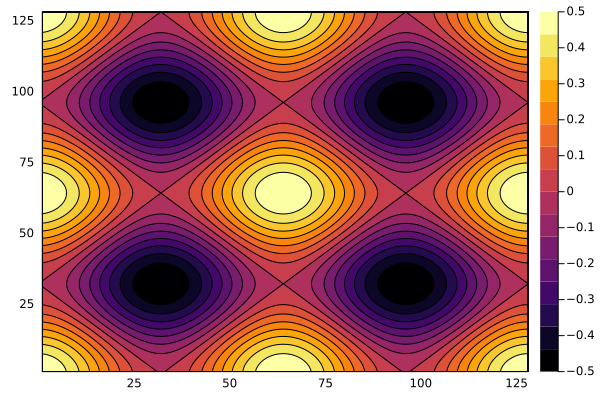

In [420]:
NN = 128
x = (1:NN)/NN .- 0.5
y = x'
pFAna = 0.25*(cos.(4π*x).+cos.(4π*y));
Plots.contourf(pFAna)

In [455]:
function flood(f::Array;shift=(0.,0.),cfill=:RdBu_11,clims=(),levels=10,kv...)
    if length(clims)==2
        @assert clims[1]<clims[2]
        @. f=min(clims[2],max(clims[1],f))
    else
        clims = (minimum(f),maximum(f))
    end
    Plots.contourf(axes(f,1).+shift[1],axes(f,2).+shift[2],f',
        linewidth=0, levels=levels, color=cfill, clims = clims, 
        aspect_ratio=:equal; kv...)
end

addbody(x,y;c=:black) = Plots.plot!(Shape(x,y), c=c, legend=false)
function body_plot!(sim;levels=[0],lines=:black,R=inside(sim.flow.p))
    WaterLily.measure_sdf!(sim.flow.σ,sim.body,WaterLily.time(sim))
    contour!(sim.flow.σ[R]';levels,lines)
end

function sim_gif!(sim;duration=1,step=0.1,verbose=true,R=inside(sim.flow.p),
                    remeasure=false,plotbody=false,kv...)
    t₀ = round(WaterLily.sim_time(sim))
    omegaInter = Float64[]
    @time @gif for tᵢ in range(t₀,t₀+duration;step)
        # Plots.plot()
        WaterLily.sim_step!(sim,tᵢ;remeasure)
        for I∈inside(sim.flow.σ)
            sim.flow.σ[I] = WaterLily.curl(3,I,sim.flow.u)*sim.L/sim.U
        end
        WaterLily.BCPer!(sim.flow.σ)
        flood(sim.flow.σ[2:end-1,2:end-1]; kv...)
        # flood(sim.inter.f[2:end-1,2:end-1,4]; kv...)
        plotbody && body_plot!(sim)
        verbose && println("tU/L=",round(tᵢ,digits=4),
            ", Δt=",round(sim.flow.Δt[end],digits=3))
        # push!(omegaInter,InterpolOmega(SA[mod(16.1+6.4*tᵢ,64),mod(16.1+12.8*tᵢ,64)], sim.flow.σ))
        push!(
            omegaInter, 
            WaterLily.Γ(sim.flow.u,(1,))
        )
    end
    return omegaInter
end

function justSim!(sim;duration=1,step=0.1,verbose=true,R=inside(sim.flow.p),remeasure=false,plotbody=false,kv...)
    N = size(sim.flow.p)[1]-2
    nn4 = Int(N/2+1)
    t₀ = round(WaterLily.sim_time(sim))
    presPeak=Float64[]
    i = 0
    @time for tᵢ in range(t₀,t₀+duration;step)
        i+=1
        WaterLily.sim_step!(sim,tᵢ;remeasure)
        i%500==1 && verbose && println("tU/L=",round(tᵢ,digits=4),
            ", Δt=",round(sim.flow.Δt[end],digits=3))
        push!(
            presPeak, (
                sim.flow.p[nn4,nn4] + 
                sim.flow.p[nn4,nn4+1] + sim.flow.p[nn4+1,nn4] + 
                sim.flow.p[nn4+1,nn4+1]
            )/4
        )
    end
    return presPeak
end

function pureSim!(sim;step=0.1,num=100,verbose=true,R=inside(sim.flow.p),remeasure=false,plotbody=false,kv...)
    N = size(sim.flow.p)[1]-2
    nn4 = Int(N/2+1)
    t₀ = round(WaterLily.sim_time(sim))
    presPeak=Float64[]
    Γall = Float64[]
    i = 0
    @time for i in 1:num
        WaterLily.mom_step!(sim.flow,sim.pois)
        sim.flow.Δt[end]=step
        i%500==1 && verbose && println("tU/L=",round(i*step*sim.U/sim.L,digits=4))
        push!(
            presPeak, 
            √Statistics.mean((sim.flow.p[R]/F2(i*step*sim.U/sim.L).-pFAna).^2)
        )
        push!(
            Γall, 
            WaterLily.Γ(sim.flow.u,(1,))
        )
    end
    return presPeak,Γall
end

pureSim! (generic function with 1 method)

In [422]:
function circle(n,m;Re=250,U=1)
    radius, center = m/8, m/2
    body = WaterLily.AutoBody((x,t)->√sum(abs2, x .- center) - radius)
    return WaterLily.Simulation((n,m), (U,0), radius; ν=U*radius/Re, body)
end

circle (generic function with 1 method)

In [423]:
function TGV(; pow=6, Re=1e5, T=Float64, mem=Array,Iper=0.5)
    # Define vortex size, velocity, viscosity
    L = 2^pow; U = 1; ν = U*L/Re
    # Taylor-Green-Vortex initial velocity field
    function uλ(i,xyz)
        x,y = @. (xyz-1.5)*π/L                # scaled coordinates
        i==1 && return -U*(sin(x)*cos(y)+Iper*sin(5x)*cos(5y)) # u_x
        i==2 && return  U*(cos(x)*sin(y)+Iper*cos(5x)*sin(5y)) # u_y
        return 0.                              # u_z
    end
    # Initialize simulation
    return WaterLily.Simulation((L, L), (0, 0), L; U=U, uλ=uλ, ν=ν, T=T, mem=mem,perdir=(0,),Δt=0.000001)
    # return WaterLily.TwoPhaseSimulation((L, L,8), (0,0,0), L;U=U, uλ=uλ, Δt=0.01, ν=ν, T=T, mem=mem,perdir=(0,),λν=1.0,λρ=1.0, InterfaceSDF=(x) -> (x[1]-1.5+x[2]-1.5)-L)
end

TGV (generic function with 1 method)

In [424]:
function TGVHalfPer(; pow=6, Re=1e5, T=Float32, mem=Array)
    # Define vortex size, velocity, viscosity
    L = 2^pow; U = 1; ν = U*L/Re
    # Taylor-Green-Vortex initial velocity field
    function uλ(i,xyz)
        x,y = @. (xyz-1.5)*2π/L                # scaled coordinates
        i==1 && return U*(sin(x)*sin(y)+0.1sin(10x)*sin(10y)+0.2*rand()+0.0) # u_x
        i==2 && return U*(cos(x)*cos(y)+0.1cos(10x)*cos(10y)+0.2*rand()+0.0) # u_y
        return 0.                              # u_z
    end
    # Initialize simulation
    return WaterLily.Simulation((L, L), (0, 0), L; U=U, uλ=uλ, ν=ν, T=T, mem=mem)
end

TGVHalfPer (generic function with 1 method)

In [457]:
sim = TGV(;Re=10000)
sim = TGV(;Re=100,Iper=0.0,pow=6)
# sim.flow.p[2:end-1,2:end-1] .= pFAna
WaterLily.BCPerNeu!(sim.flow.p;perdir=(0,))
# sim = TGVHalfPer(;Re=10000)
# sim = circle(3*2^6,2^7)

In [426]:
computationID = "2dTGV_Pcorrect_Pdt_Pnavigate"

"2dTGV_Pcorrect_Pdt_Pnavigate"

In [427]:
dur,stp = 5,0.01
num,stp = 12800,0.05
tSeries = Array(0:stp:dur);

In [428]:
size(presAna)
size(presVal_correct)

MethodError: MethodError: no method matching size(::Tuple{Vector{Float64}, Vector{Float64}})

Closest candidates are:
  size(::Tuple, !Matched::Integer)
   @ Base tuple.jl:27
  size(!Matched::Union{LinearAlgebra.QR, LinearAlgebra.QRCompactWY, LinearAlgebra.QRPivoted})
   @ LinearAlgebra /usr/share/julia/stdlib/v1.9/LinearAlgebra/src/qr.jl:582
  size(!Matched::Union{LinearAlgebra.QR, LinearAlgebra.QRCompactWY, LinearAlgebra.QRPivoted}, !Matched::Integer)
   @ LinearAlgebra /usr/share/julia/stdlib/v1.9/LinearAlgebra/src/qr.jl:581
  ...


In [458]:
omegaInter = sim_gif!(sim,duration=10, step=0.01,clims=(-5,5),plotbody=false,verbose=false,levels=32);
# presVal = justSim!(sim,duration=dur, step=stp);
# presVal,ΓVal = pureSim!(sim,num=num, step=stp);

# presVal[1] = 0.5
save(computationID*"_presVal.jld", "data", presVal)


218.547385 seconds (53.18 M allocations: 2.736 GiB, 0.59% gc time)


┌ Info: Saved animation to /tmp/jl_YZszOrKpA1.gif
└ @ Plots /home/tyhuang/.julia/packages/Plots/3BCH5/src/animation.jl:156


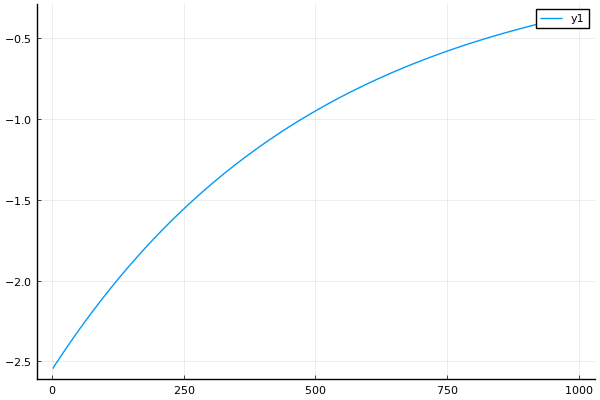

In [463]:
Plots.plot(omegaInter/(sim.U*sim.L))

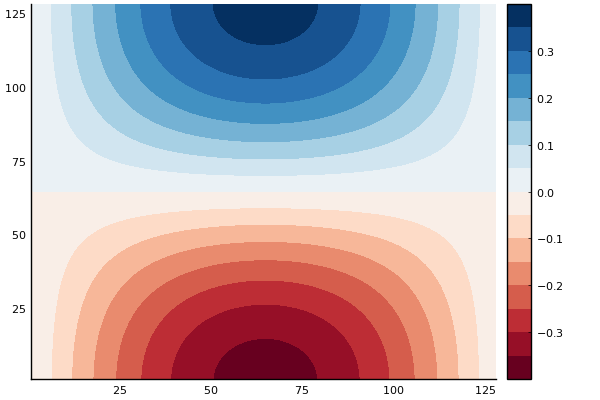

In [452]:
Plots.contourf(sim.flow.u[2:end-1,2:end-1,1]',color=:RdBu)

In [431]:
tSeries = ((1:num)*stp)*sim.U/sim.L
presAna = 0.5*exp.(-2*tSeries*(8*pi^2)/100);

In [432]:
presVal_correct = load("2dTGV_Pcorrect_Pdt_Pnavigate_presVal.jld")["data"];
presVal_wrong = load("2dTGV_Pwrong_Pdt_Pnavigate_presVal.jld")["data"];

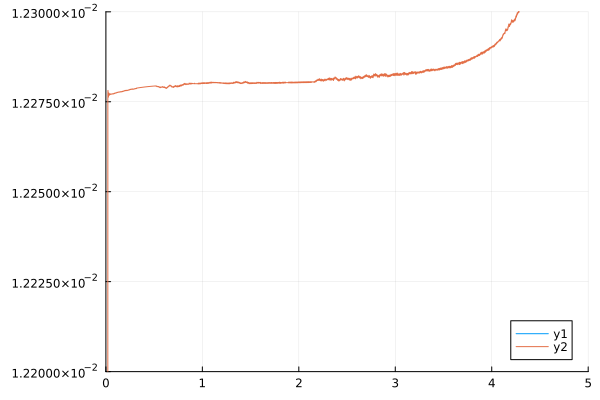

In [433]:
Plots.plot()
# Plots.plot!(tSeries,movingaverage(presVal,100))
Plots.plot!(tSeries,movingaverage(presVal_correct,100))
Plots.plot!(tSeries,movingaverage(presVal_wrong,100))
# Plots.plot!(tSeries,movingaverage(presVal./presAna,100))
# Plots.plot!(tSeries,movingaverage(presVal_correct./presAna,100).-1)
# Plots.plot!(tSeries,movingaverage(presVal_wrong./presAna,100).-1)
# Plots.plot!(tSeries,movingaverage((presVal_correct-presVal_wrong),1))
# Plots.plot!(tSeries,presAna./presAna)
Plots.plot!(xlimit=[0,5],ylimit=[0.0122,0.0123])

In [434]:
size(movmean(presVal_correct./presAna,10))

(12791,)

In [435]:
#save("omega_Stay.jld", "data", -omegaInter)

In [436]:
omega_Stay = load("omega_Stay.jld")["data"];
omega_Moving = load("omega_Moving.jld")["data"];
t = range(0.00,5,501)

omega_ini = omega_Stay[1];
omega_Ana = omega_ini*exp.(-8*pi^2/100*t);

In [437]:
pythonplot()
plot(t, (omega_Stay[1:end]-omega_Ana[1:end])./omega_Ana[1:end], label="Stationary")
plot!(t, (omega_Moving[1:end]-omega_Ana[1:end])./omega_Ana[1:end],legend=:topleft, label="Traveling")
savefig("TGVHalfPer_TravelingStationaryOmegaError.png")

# plot!()

"/home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/TGVHalfPer_TravelingStationaryOmegaError.png"

In [438]:
pythonplot()
plot(t, omega_Ana[1:end])
savefig("TGVHalfPer_AnalyticalOmega.png")

"/home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/TGVHalfPer_AnalyticalOmega.png"

In [439]:
aa = cumsum(sim.flow.Δt)[1:end-1]*sim.U/sim.L;


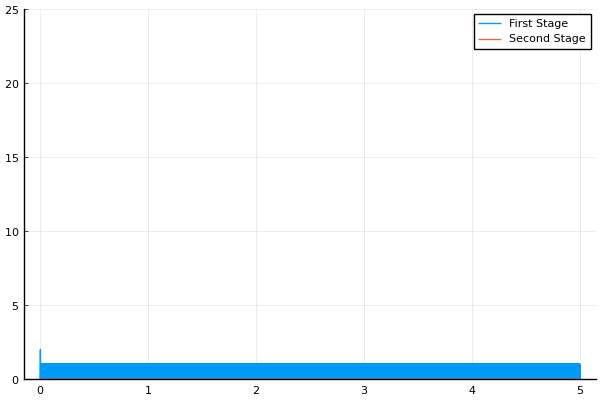

In [440]:
Plots.plot(aa,sim.pois.n[1:2:end],label="First Stage")
Plots.plot!(aa,sim.pois.n[2:2:end],label="Second Stage")
Plots.plot!(ylimit=[0,25])
Plots.savefig(computationID*"_PoisNum.png")
Plots.plot!()

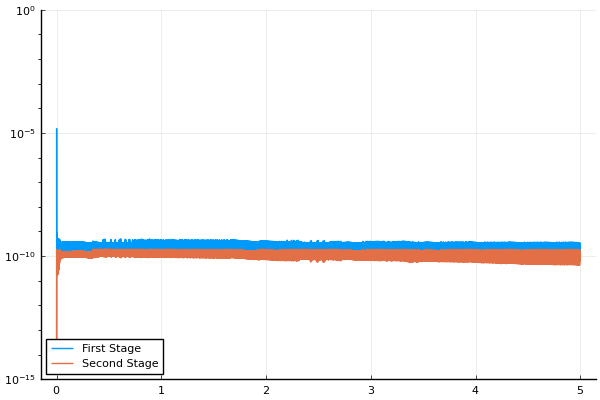

In [441]:
Plots.plot(aa,sim.pois.res0[1:2:end],yscale=:log10,label="First Stage")
Plots.plot!(aa,sim.pois.res0[2:2:end],yscale=:log10,label="Second Stage",legend=:bottomleft,ylimit=[1e-15,1])
# Plots.plot(aa,sim.pois.res[2:2:end]./sim.pois.res[1:2:end],label="First Stage",ylimit=[0,10])
Plots.savefig(computationID*"_PoisIniRes.png")
Plots.plot!()

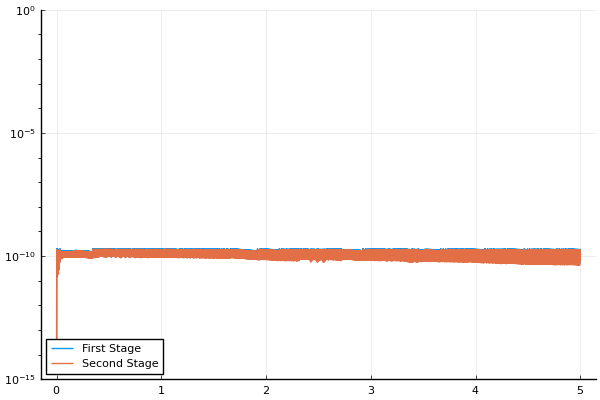

In [442]:
Plots.plot(aa,sim.pois.res[1:2:end],yscale=:log10,label="First Stage")
Plots.plot!(aa,sim.pois.res[2:2:end],yscale=:log10,label="Second Stage",legend=:bottomleft,ylimit=[1e-15,1])
# Plots.plot(aa,sim.pois.res[2:2:end]./sim.pois.res[1:2:end],label="First Stage",ylimit=[0,10])
Plots.savefig(computationID*"_PoisFinRes.png")
Plots.plot!()

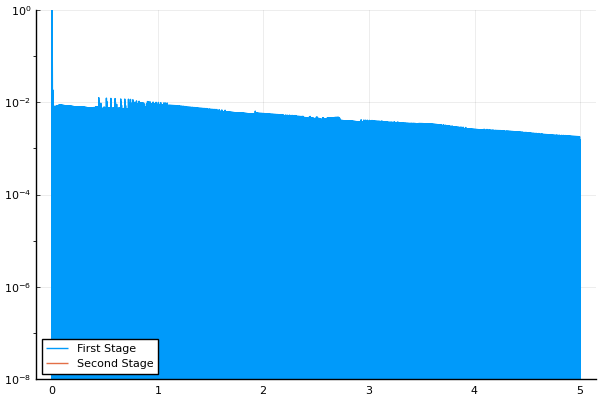

In [443]:
clamp!(sim.flow.pd,1e-16,10000)
Plots.plot(aa,sim.flow.pd[1:2:end],yscale=:log10,label="First Stage")
Plots.plot!(aa,sim.flow.pd[2:2:end],yscale=:log10,label="Second Stage",legend=:bottomleft,ylimit=[1e-8,1])
Plots.savefig(computationID*"_PoisPresDiff.png")
# Plots.plot(aa,abs.(sim.flow.pd[2:2:end])./sim.flow.pd[1:2:end],ylimit=[0,2],label="First Stage")
# Plots.plot(clamp.(sim.flow.pd,1e-10,10),yscale=:log10,label="First Stage")
Plots.plot!()


(12800,)


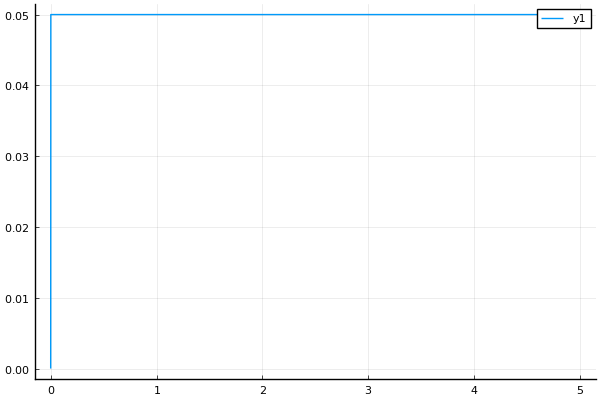

In [444]:
println(size(sim.flow.Δt[1:end-1]))
Plots.plot(aa,sim.flow.Δt[1:end-1])


In [445]:
Plots.contourf(sim.flow.u[2:end-1,2:end-1,4,1], aspect_ratio=:equal,color=:seismic,levels=60)
Plots.contourf(sim.inter.n̂[:,:,4,1], aspect_ratio=:equal,color=:seismic,levels=60)
Plots.contourf(sim.inter.f[:,:,4], aspect_ratio=:equal,color=:seismic,levels=60)

BoundsError: BoundsError: attempt to access 130×130×2 Array{Float64, 3} at index [2:129, 2:129, 4, 1]

In [446]:
sim.inter.n̂[]

ErrorException: type Simulation has no field inter

In [447]:
aa = zeros(4,4,2)
aa[2:4,3,1] .= [1, 2, 3]
aa[2:4,4,1] .= [2,4,6]
WaterLily.Γ(aa,(1,))

-6.0

In [448]:
WaterLily.Γ(sim.flow.u[:,:,1:2],(1,))

-121.48135020704186

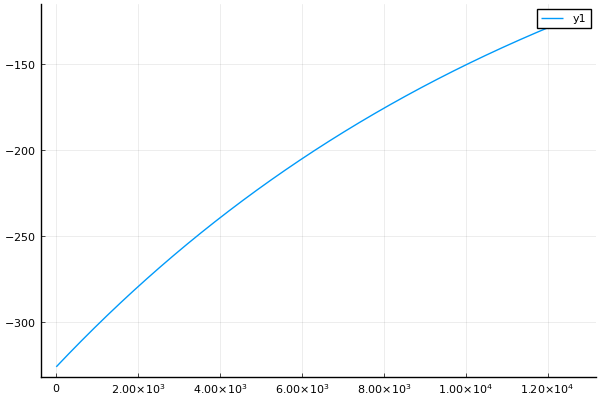

In [450]:
Plots.plot(ΓVal)